## Pretraining on Unlabeled Data

This notebook covers Chapter 4 of [*Build a Large Language Model from Scratch*](https://www.manning.com/books/build-a-large-language-model-from-scratch) by Sebastian Raschka (2025).

**Load all the relevant building blocks:**

In [1]:
import torch
import torch.nn as nn
import tiktoken

# tokenizer:
tokenizer = tiktoken.get_encoding("gpt2")

# LayerNorm:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # small constant to prevent division by 0 errors:
        self.eps = 1e-5

        # trainable parameters to scale and shift weights
        # if model feels that doing so will improve 
        # the training:
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mu = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # no Bessel correction (n-1)
        norm_x = (x - mu) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

# GELU:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

# feed forward:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

# multi-head attention:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # logic check:
        assert (d_out % num_heads == 0), "Error: d_out must be divisible by num_heads!"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # final embedding size

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # linear layer for head outputs
        # (not strictly necessary, but commonly used):
        self.out_proj = nn.Linear(d_out, d_out)

        # dropout:
        self.dropout = nn.Dropout(dropout)

        # register buffer:
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape

        # queries, keys, values
        # of shape (batch_size, num_tokens, d_out):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        
        # split the matrices:
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        # transpose from (batch_size, num_tokens, num_heads, head_dim)
        # to (batch_size, num_heads, num_tokens, head_dim):
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # attention scores:
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # mask
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        # context vectors:
        context_vec = (attn_weights @ values).transpose(1, 2) # (1, 2) --> (num_tokens, num_heads)
        context_vec = context_vec.contiguous().view( # tensor of shape (batch_size, num_tokens, num_heads, head_dim)
            batch_size, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

# transformer block:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # attention:
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            dropout=config["drop_rate"],
            qkv_bias=config["qkv_bias"]
        )

        # feed forward:
        self.ff = FeedForward(config)

        # norm:
        self.norm1 = LayerNorm(config["emb_dim"])
        self.norm2 = LayerNorm(config["emb_dim"])
        
        # dropout with shortcut:
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x

        # pre-layer norm:
        x = self.norm1(x)

        # attention:
        x = self.attention(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x

        # pre-layer norm:
        x = self.norm2(x)

        # feed forward network:
        x = self.ff(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

Assemble the GPT model:

In [2]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # token embeddings of shape (n_tokens, embedding_dims):
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])

        # positional embeddings of shape (context_length, embedding_dims):
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        # dropout:
        self.drop_emb = nn.Dropout(config["drop_rate"])

        # N transformer blocks (corresponds to n_layers):
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(config) for _
                in range(config["n_layers"])
            ]
        )

        # normalization:
        self.final_norm = LayerNorm(config["emb_dim"])

        # final output head:
        self.out_head = nn.Linear(
            config["emb_dim"], config["vocab_size"], bias=False
        )

    # forward pass:
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embeddings = self.tok_emb(in_idx)
        pos_embeddings = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = token_embeddings + pos_embeddings
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

And the function for greedy text generation:

In [3]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # truncate to only the last N tokens in the context_size:
        idx_cond = idx[:, -context_size:]
        
        # predict:
        with torch.no_grad():
            logits = model(idx_cond)
        
        # focus on the last step
        # (batch, vocab_size):
        logits = logits[:, -1, :]

        # get probabilities:
        probs = torch.softmax(logits, dim=-1)

        # get next token index with the highest probability:
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        # append next token to previous inputs:
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

Load the model:

In [4]:
torch.manual_seed(123)

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # reduce for example
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear

Two new functions for converting text to token IDs and token IDs to text:

In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # un-squeezing adds batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # squeezing removes the batch dimension
    return tokenizer.decode(flat.tolist())

Test:

In [6]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### Assembling a loss metric

Clearly, the model cannot generate coherent text yet. It needs to bet rained to do so, and we need a loss metric to measure how well the model is learning.

Assume we have these input tensors:

In [7]:
inputs = torch.tensor([[16833, 3626, 6100], # --> "every effort moves"
                       [40, 1107, 588]])    # --> "I really like" 

And these targets:

- **Note:** remember that the targets are the token IDs we want the model to produce, and correspond to the inputs shifted "to the right" by one.

In [8]:
targets = torch.tensor([[3626, 6100, 345],   # --> "effort moves you"
                        [1107, 588, 11311]]) # --> "really like chocolate"

Pass the inputs through the model to get the logits:

In [9]:
with torch.no_grad():
    logits = model(inputs)
probs = torch.softmax(logits, dim=-1)
print(probs)
print(probs.shape)

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])
torch.Size([2, 3, 50257])


The shape corresponds to:

- `2` $\rightarrow$ the batch size
- `3` $\rightarrow$ the number of tokens in each input
- `50257` $\rightarrow$ the vocabulary size

How can we retrieve the relevant tokens? Use `argmax`:

In [10]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print(f"Token IDs:\n {token_ids}")

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


Retrieve the text:

In [11]:
for batch in range(len(token_ids)):
    i = batch + 1
    print(f"Targets batch {i}: {token_ids_to_text(targets[batch], tokenizer)}")
    print(f"Outputs batch {i}: {token_ids_to_text(token_ids[batch].flatten(), tokenizer)}")
    print(f"-"*50)

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
--------------------------------------------------
Targets batch 2:  really like chocolate
Outputs batch 2:  pressuring empoweredfaith
--------------------------------------------------


Token probabilities:

In [12]:
for batch in range(len(token_ids)):
    i = batch + 1
    print(f"Target probs {i}: {probs[batch, [0, 1, 2], targets[batch]]}")
    print(f"-"*60)

Target probs 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
------------------------------------------------------------
Target probs 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
------------------------------------------------------------


To measure loss, we want to minimize the ***negative average log probability***:

- That is, we want to bring the negative average log probability as close to `0` as possible.
- In practice negative average log probability is often used interchangeable with ***cross-entropy loss***.

In [13]:
target_probs_1 = probs[batch, [0, 1, 2], targets[0]]
target_probs_2 = probs[batch, [0, 1, 2], targets[1]]

log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
avg_log_probs = torch.mean(log_probs)
neg_avg_log_probs = avg_log_probs * -1

print(f"Negative avg. log probs: {neg_avg_log_probs}")

Negative avg. log probs: 10.981441497802734


We can simply use PyTorch's `cross_entropy` method instead.

Recall the shapes of our tensors:

In [14]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


We need to *flatten* and *combine* these tensors across the batch dimension:

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten(0)

print(f"Flat logits shape: {logits_flat.shape}")
print(f"Flat targets shape: {targets_flat.shape}\n")

print(f"Flat logits:\n {logits_flat}\n")
print(f"Flat targets:\n {targets_flat}")

Flat logits shape: torch.Size([6, 50257])
Flat targets shape: torch.Size([6])

Flat logits:
 tensor([[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
        [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
        [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217],
        [-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
        [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
        [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]])

Flat targets:
 tensor([ 3626,  6100,   345,  1107,   588, 11311])


Now we can do cross-entropy:

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"Loss: {loss}")

Loss: 10.793964385986328


What about ***perplexity***?

> "Perplexity measures howe well the probability distribution predicted by the model matches the actual distribution of the words in the dataset...Perplexity is often considered more interpretable than the raw loss value because it signifies the effective ***vocabulary size about which the model is uncertain at each step***." (Raschka 2025:139).

- For example, a perplexity of `48725.82` would suggest the model is unsure of $~48,725$ tokens to generate next.

Perplexity can be easily calculated by calling `torch.exp` on the loss:

In [17]:
print(f"Perplexity: {torch.exp(loss):.2f}")

Perplexity: 48725.82


#### Training and validation loss

Let's use *The Verdict* as our example:

In [18]:
file = "the-verdict.txt"
with open(file, "r", encoding="UTF-8") as f:
    text_data = f.read()

total_chars = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Characters: {total_chars}")
print(f"Tokens: {total_tokens}")

Characters: 20479
Tokens: 5145


Create a data loader (see ch. 2):

In [19]:
from torch.utils.data import Dataset, DataLoader

# more efficient data handling:
class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        """PyTorch data loader.

        Args:
            text (str): the raw text string.
            tokenizer (Any): the tokenizer.
            max_length (int): the max length of the sequence.
            stride (int): the sliding window size.
        """
        self.input_ids = []
        self.target_ids = []

        # encode:
        token_ids = tokenizer.encode(text)

        # get inputs and targets:
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i: i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # __len__ gets total number of rows in dataset:
    def __len__(self):
        return len(self.input_ids)
    
    # __getitem__ returns a single row from the dataset:
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
    
# data loader:
def create_dataloader_v1(text, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, 
                         num_workers=0):
    
    # fetch tokenizer:
    tokenizer = tiktoken.get_encoding("gpt2")

    # create dataset:
    dataset = GPTDatasetV1(text, tokenizer, max_length, stride)

    # create data loader:
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, # if last batch is shorter than batch size, then it is dropped (this prevents loss spikes).
        num_workers=num_workers
    )

    return dataloader

Create the train and dev sets:

In [20]:
torch.manual_seed(123)

train_ratio = 0.90 # 90% for training
split_idx = int(train_ratio*len(text_data)) # index to split
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

Inspect:

In [21]:
print("Train Loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation Loader:")
for x,y in val_loader:
    print(x.shape, y.shape)


Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation Loader:
torch.Size([2, 256]) torch.Size([2, 256])


Function for cross-entropy loss:

In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

A helper function to compute loss over all batches:

In [23]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0. # cumulative loss
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss
        else:
            break
    return total_loss / num_batches # average loss across all batches

Test it out:

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    eval_loss = calc_loss_loader(val_loader, model, device)

print(f"training loss: {train_loss:.3f}")
print(f"evaluation loss: {eval_loss:.3f}")

training loss: 10.988
evaluation loss: 10.981


In [25]:
device

device(type='cpu')

### Finally, pretrain the LLM

Bring it all together into a training loop.

**Note:** we use the ***AdamW*** optimizer.

- Adam optimizers are extremely popular.
- AdamW is chosen over base Adam due to improved handling of weight decay.
    - AdamW helps minimize complexity and overfitting by penalizing large weights. 
- AdmW has more effective regularization and generalization.

Create a function to contain the training loop:

In [26]:
# function for evaluation:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


# function for printing examples during training:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))


# function for training:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses = []
    val_losses = []
    track_tokens_seen = []

    tokens_seen = 0
    global_step = -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            # reset gradients:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # loss gradients:
            loss.backward()

            # update weights with gradients:
            optimizer.step()

            # update seen tokens:
            tokens_seen += input_batch.numel()
            global_step += 1

            # eval step:
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch: {epoch+1} (Step {global_step:06d})")
                print(f"Training loss: {train_loss:.3f}")
                print(f"Validation loss: {val_loss:.3f}")
                print(f"-"*30)
            
            # print example:
            generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

And run it:

In [27]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10
start_context = "Every effort moves you"

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer,
    device, num_epochs=num_epochs, eval_freq=5,
    eval_iter=5, start_context=start_context,
    tokenizer=tokenizer
)

Epoch: 1 (Step 000000)
Training loss: 9.783
Validation loss: 9.927
------------------------------
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Every effort moves you,.                                                
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,, the the, the the,,,,, the,,,, the,,,,, the the the, the,, the the the,, the the the, the the the the,,,,,
Epoch: 1 (Step 000005)
Training loss: 7.986
Validation loss: 8.328
------------------------------
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Every effort moves you, the,, the the the the the the the the the the the the the, the the the the the,, the the the.                     
Every effort m

Let's inspect the lsos:

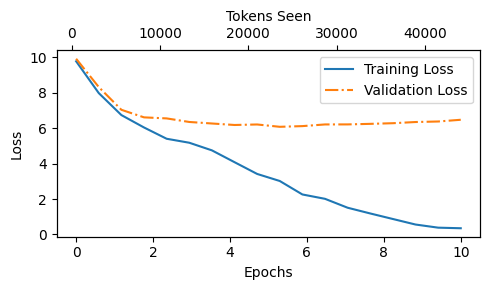

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_lsses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training Loss")
    ax1.plot(epochs_seen, val_losses, ls="-.", label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens Seen")
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)) 
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The divergence between the lines shows that the model is ***overfitting*** to the training data. It will even memorize passages from the text verbatim.

- This is related to the small training data and the multiple epochs.
- In reality, it's quite common to train on a large dataset for only a single epoch.

### Decoding strategies to control randomness

Ask the model to generate some text:

In [29]:
# device and eval mode:
model.to("cpu") # it should already be here anyway
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Generated text:\n {token_ids_to_text(token_ids, tokenizer)}")

Generated text:
 Every effort moves you?"
"I didn't, and I haven't seen a single one in the house."
"Oh, and he


The model will always generate the same, most probable (i.e., "greedy" decoding), outcomes using the naive method. We can use ***temperature scaling*** to introduce more variety. 

#### Temperature Scaling

An example of probabilistic sampling using a small vocabulary:

In [30]:
# toy vocabulary:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}

inverse_vocab = {v:k for k,v in vocab.items()}

# assume our starting sequence is 'every effort moves you'
# and it produced the following next-token logits:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# we get the probabilities with softmax:
probs = torch.softmax(next_token_logits, dim=0)

# and the next token ID:
next_token_id = torch.argmax(probs).item()
print(f"Next token: '{inverse_vocab[next_token_id]}'")

Next token: 'forward'


Instead of using simply the most probable token, let's sample from a multinomial distribution:

In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(f"Sampled token: '{inverse_vocab[next_token_id]}'")

Sampled token: 'toward'


We can see the effect of sampling by looping:

In [32]:
def print_sampled_tokens(probs):
    torch.manual_seed(123)
    sample = [torch.multinomial(probs, num_samples=1).item()
              for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probs)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Let's introduce ***temperature scaling***:
- All that happens is the logits are divided by some number greater than $0$. 
- Temperatures greater than $1$ create "sharper" distributions with more "peaks (and therefore more "confidence").
    - A temperature of $1$ is as if the temperature was not applied at all.
    - Temperatures closer to $0$ are closer to the naive argmax function.

In [33]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

Plot an example:

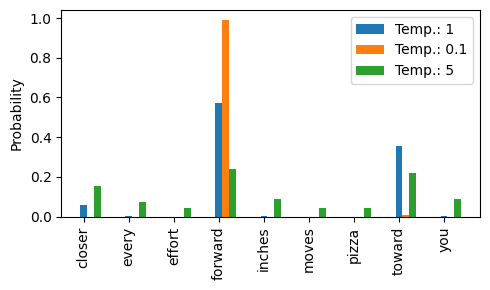

In [34]:
temperatures = [1, 0.1, 5]
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    recs = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f"Temp.: {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#### Top-k sampling

Temperature scaling can sometimes result in grammatically incorrect or nonsensical outptus. To correct for this, we can use ***top-k sampling*** the restricts the sampled tokens to the top-k most likely tokens: all others are excluded.
- All non-selected logits are replaced with $-\infty$, resulting in probabilities of $0$ after passing through the softmax.
- The remaining probabilities of selected tokens sum to $1$.

In [35]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(f"Top logits: {top_logits}")
print(f"Top token positions: {top_pos}")

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top token positions: tensor([3, 7, 0])


Mask out the excluded tokens:

In [36]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # lowest logit value from top-k sample
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(f"New logits: {new_logits}")

New logits: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Use softmax to convert these into probabilities:

In [37]:
topk_probs = torch.softmax(new_logits, dim=0)
print(topk_probs)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


We can now modify the `generate` function to take advantage of these improvements:

In [38]:
def generate(model, idx, max_new_tokens,
             context_size, temperature=0.0,
             top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        # top K:
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )
        # temperature scaling:
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

And test:

In [39]:
torch.manual_seed(123)

model.eval()

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(f"Generated text\n: {token_ids_to_text(token_ids, tokenizer)}")

Generated text
: Every effort moves you know began to happen a little wild--I was such struck by his last


#### Loading pretrained weights from OpenAI

Rather than train an entire model from scratch, we can use the weights from OpenAI's GPT-2 model:

In [40]:
# download the GPT download script:
import urllib.request 
url = (
    "https://raw.githubusercontent.com/rasbt/" 
    "LLMs-from-scratch/main/ch05/" 
    "01_main-chapter-code/gpt_download.py"
) 
filename = url.split('/')[-1] 
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7fe5cb093b50>)

Load the script and download the files:

In [41]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

2025-04-03 11:11:35.011741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743693095.055138   39253 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743693095.067508   39253 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743693095.169341   39253 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743693095.169393   39253 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743693095.169396   39253 computation_placer.cc:177] computation placer alr

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


Inspect:

In [42]:
print(f"Settings: {settings}")
print(f"Parameter dictionary keys: {params.keys()}")

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


Here, the `settings` dictionary contains the LLM model settings, similar to `GPT_CONFIG_124M`. The `params` dictionary contains the model weights.

We can inspect the weights, such as those for the token embeddings, contained in `wte`:

In [43]:
print(f"Token embedding weight tensor dimensin: {params['wte'].shape}")
print(f"Token embeddings:\n {params['wte']}")

Token embedding weight tensor dimensin: (50257, 768)
Token embeddings:
 [[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]


Now that we've loaded the weights, we can transfer them into our GPT-2 model:

In [44]:
gpt2_model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

With this configuration table, we can set the model we want and update the values of `GPT_CONFIG_124M` with the corresponding parameters:

In [45]:
# set the model (must be a key in `gpt2_model_configs`)
model_name = "gpt2-small (124M)"

# copy our config:
NEW_CONFIG = GPT_CONFIG_124M.copy()

# update the values:
NEW_CONFIG.update(gpt2_model_configs[model_name])

# we must also update the token length to match `1024`:
NEW_CONFIG.update({"context_length": 1024})

# inspect:
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


OpenAI also uses bias vectors in the multi-head attention linear layers, so let's update that:

In [46]:
# update:
NEW_CONFIG.update({"qkv_bias": True})

# inspect:
for k,v in NEW_CONFIG.items():
    print(f"{k}: {v}")

vocab_size: 50257
context_length: 1024
emb_dim: 768
n_heads: 12
n_layers: 12
drop_rate: 0.1
qkv_bias: True


Finally, we use the updated config to create a fresh GPT model:

In [47]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

And now let's override the randomly generated weights with the pretrained weights from OpenAI:

In [48]:
import numpy as np

# helper function for assigning weights:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch! Left: {left.shape} | Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


# function for loading the weights:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        # divide attention and bias weights into three equal parts for Q,K,V:
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.weight = assign(gpt.trf_blocks[b].attention.W_query.weight, q_w.T) 
        gpt.trf_blocks[b].attention.W_key.weight = assign(gpt.trf_blocks[b].attention.W_key.weight, k_w.T) 
        gpt.trf_blocks[b].attention.W_value.weight = assign(gpt.trf_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.bias = assign(gpt.trf_blocks[b].attention.W_query.bias, q_b) 
        gpt.trf_blocks[b].attention.W_key.bias = assign(gpt.trf_blocks[b].attention.W_key.bias, k_b) 
        gpt.trf_blocks[b].attention.W_value.bias = assign(gpt.trf_blocks[b].attention.W_value.bias, v_b)

        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # reuse the token embeddings weights ("weight tying"):
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

Load the model:

In [49]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

Success! Now, let's test:

In [50]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Hillary Clinton is the Democratic", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print(f"Generated text:\n {token_ids_to_text(token_ids, tokenizer)}")

Generated text:
 Hillary Clinton is the Democratic nominee for president in 2016, Donald Trump is already on board" – not necessarily at the end of a campaign to become the


Loading the weights appears to have worked: we get coherent (albeit imperfect) text!